# Predicting Stock Market Movement using a HMM

## Data Loading

We will be focusing on analysing BTC-USD data. The reason for the choice of this over a stock is because there is no underlying value and so the price is driven entirely by market sentiment, we hope this will remove the effects of unseen information such as general market news. In recent years Bitcoin has become a similar security to gold - often used to diversify a portfolio in times of market uncertainty. We will thus model data pre-2019, and compare it to a model which uses the latest data. 

In [1]:
import yfinance as yf 
from datetime import datetime
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import requests


now = datetime.now().strftime("%Y-%m-%d") 
data = yf.download("BTC-USD", start="2000-01-01", end=now, interval="1d", multi_level_index=False)
data.head


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of                     Close           High            Low           Open  \
Date                                                                     
2014-09-17     457.334015     468.174011     452.421997     465.864014   
2014-09-18     424.440002     456.859985     413.104004     456.859985   
2014-09-19     394.795990     427.834991     384.532013     424.102997   
2014-09-20     408.903992     423.295990     389.882996     394.673004   
2014-09-21     398.821014     412.425995     393.181000     408.084991   
...                   ...            ...            ...            ...   
2025-07-23  118754.960938  120113.351562  117391.390625  119997.445312   
2025-07-24  118368.000000  119535.453125  117247.968750  118770.984375   
2025-07-25  117635.882812  118486.976562  114759.820312  118368.000000   
2025-07-26  117947.367188  118335.687500  117181.226562  117644.843750   
2025-07-27  119448.492188  119815.593750  117859.687500  117944.726562   

       

## Variables

Our model will use 3 variables to train the model:
1. Volume - we hope this provides some indication to volatility 
2. Maximum daily fractional change - should also indicate volatility 
3. Daily fractional change - some indication of sentiment

The latent states should measure the type of market we are in i.e Bear, Bull or Sideways. 



## Data cleanup 

A quick look at the volume data shows why we have opted to making two models. We see that there is a much larger volume of BTC being traded after index 1500

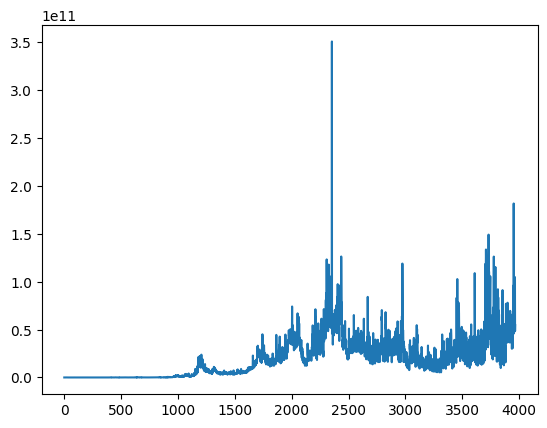

In [2]:
plt.plot([i for i in range(len(data["Volume"]))], data["Volume"])
plt.show()

There is a significant change in volume which becomes stabilises post 2011. This is likely due to the influx of high frequency trading bots around this time however whatever the reason we will only consider data after 2011 so that it is more relevant to the current market conditions. 

[*********************100%***********************]  1 of 1 completed


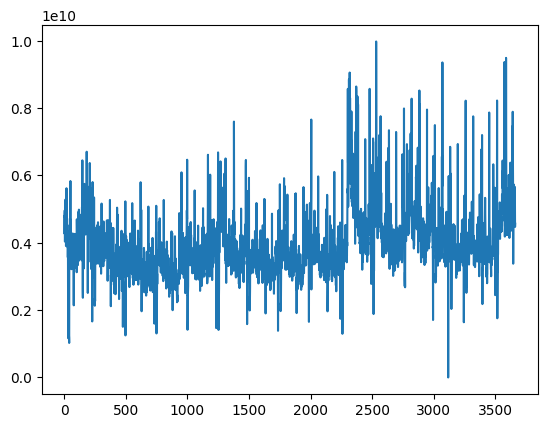

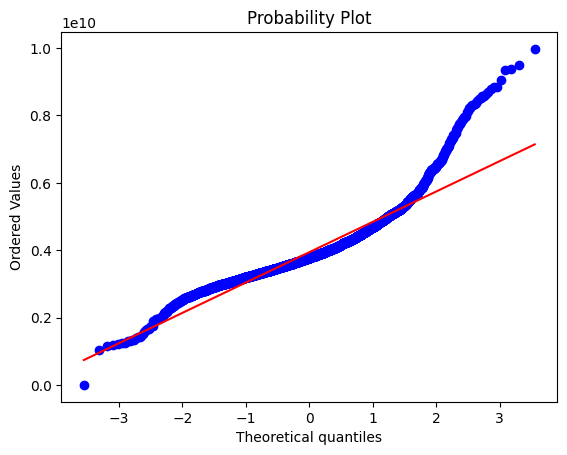

In [3]:
data = yf.download("^GSPC", start="2011-01-01", end=now, interval="1d", multi_level_index=False)
plt.plot([i for i in range(len(data["Volume"]))], data["Volume"])
plt.show()
import pylab 
import scipy.stats as stats

#QQ plot suggests a heavy tailed distribution such as a power law dist 
stats.probplot(data["Volume"], dist="norm", plot=pylab)
pylab.show()


In [4]:
#creating latent variables 
def observed_states(dataframe):
    dataframe["daily_change"] = (dataframe["Close"] - dataframe["Open"])/(dataframe["Open"])
    dataframe["max_change"] = (dataframe["High"] - dataframe["Low"])/(dataframe["Low"])
    return dataframe
    


In [5]:
data = observed_states(data)
#Using an 80-20 training/test split 
train_size = int(0.8 * data.shape[0])
train_data = data.iloc[0:train_size]
test_data = data.iloc[train_size+1:]

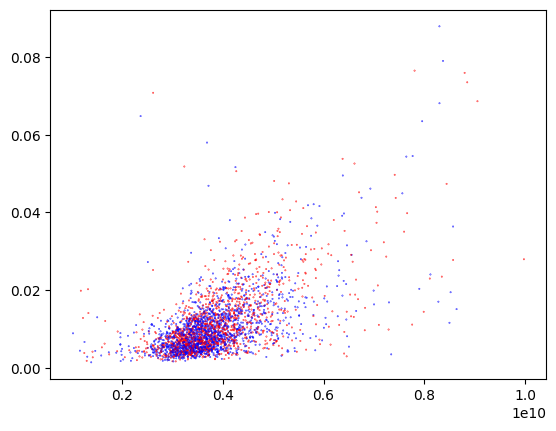

In [6]:
train_daily = train_data["daily_change"]
train_max = train_data["max_change"]
train_vol = train_data["Volume"]

colors = np.where(train_daily < 0, "red", "blue")

plt.scatter(train_vol, train_max, s=0.1, c=colors)
plt.show()



<Figure size 1000x400 with 0 Axes>

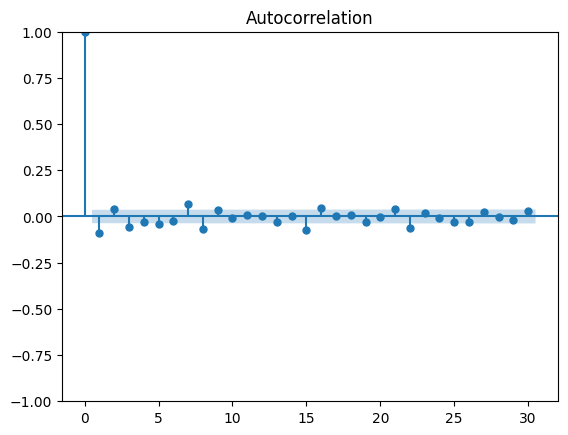

<Figure size 1000x400 with 0 Axes>

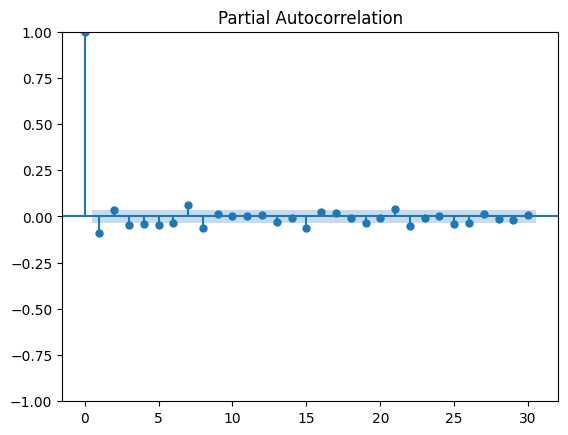

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(10,4))
plot_acf(train_daily, lags=30)
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plt.figure(figsize=(10,4))
plot_pacf(train_daily, lags=30)
plt.show()


In [9]:
train_data_x = np.column_stack([train_vol, train_max, train_daily])


from hmmlearn import hmm 
#model hyperparameters
num_hidden = 2
n_iter = 1000
covariance_type = "diag"
model = hmm.GaussianHMM(n_components=num_hidden, n_iter=n_iter, covariance_type="diag")
model.fit(train_data_x)

Model is not converging.  Current: -42359.754872866724 is not greater than -42359.09197383684. Delta is -0.6628990298850113


GaussianHMM(n_components=2, n_iter=1000)

In [10]:
test_data = features(test_data)
test_log_vol = np.log(test_data["Volume"])
test_daily = test_data["daily_change"]
test_max = test_data["max_change"]

test_data_for_predict = np.column_stack([test_log_vol, test_max, test_daily])

NameError: name 'features' is not defined

In [ ]:
#create a discretised event space for markov model to predict between 
disc_max = np.linspace(np.min(train_max), np.max(train_max), 10)
disc_daily = np.linspace(np.min(train_daily), np.max(train_daily), 50) #extra values here as this is used for prediction 
disc_vol = np.linspace(np.min(train_log_vol), np.max(train_log_vol), 10)

#create a grid for search
from itertools import product
from tqdm import tqdm 


grid = np.array(list(product(disc_vol, disc_max, disc_daily)))

In [ ]:
test_data_for_predict[0]

array([ 2.19614314e+01,  3.31090676e-03, -1.22131653e-03])

In [ ]:
test_predicted = []
for day in tqdm(range(len(test_daily[1:50]))):
    #previous days obsered values 
    obsv = test_data_for_predict[:day-1]
    #loop over potential states 
    pos_scores = []
    for pos_obsv in grid:
        #collated data
        model_data = np.row_stack([obsv, pos_obsv])
        #compute likelihood 
        score = model.score(model_data)
        pos_scores.append(score)
        
    pos_outcome = grid[np.argmax(pos_scores)]
    test_predicted.append(test_data.iloc[day]['Open'] * (1 + pos_outcome[2]))


100%|██████████| 49/49 [00:17<00:00,  2.77it/s]


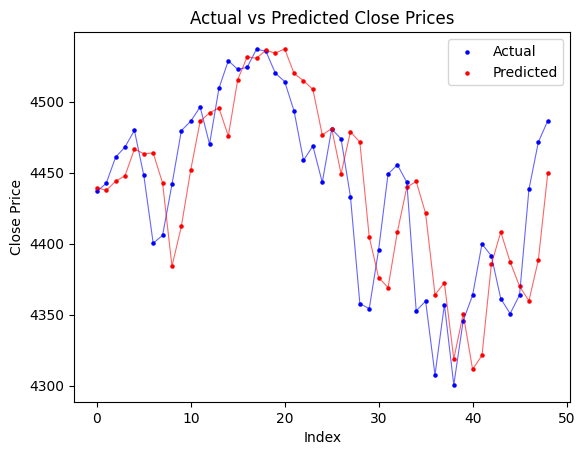

In [ ]:
import matplotlib.pyplot as plt

# Generate x-axis indices
x_values = [i for i in range(len(test_data[1:50]))]

# Scatter plot for actual data
plt.scatter(x_values, test_data.iloc[1:50]["Close"], s=5, label="Actual", color='blue')

# Scatter plot for predicted data
plt.scatter(x_values, test_predicted, s=5, label="Predicted", color='red')

# Line plot to connect actual data points
plt.plot(x_values, test_data.iloc[1:50]["Close"], linestyle="-", linewidth=0.8, color='blue', alpha=0.6)

# Line plot to connect predicted data points
plt.plot(x_values, test_predicted, linestyle="-", linewidth=0.8, color='red', alpha=0.6)

# Add labels and legend
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Prices")
plt.legend()

# Show the plot
plt.show()
